# Sample size

*Подготовил Ян Пиле*

Часто, когда собираются проводить АБ-тест, процесс происходит следующим образом:
    
1) К вам приходит менеджер и говорит: "Хочу провести АБ с нововведением Х и увеличить тем самым метрику Y" (например $X = \text{новый алгоритм ранжирования в ленте новостей}$, а $Y = CTR$\)

2) "А какой размер эффекта мы хотим увидеть?"-, спрашиваете Вы.

3) "Какой будет, такой и хотим увидеть,"- отвечает менеджер

Естественно, так ничего не заработает :) Очевидно вы понимаете, что для измерения любого сколь угодно малого эффекта вам нужно иметь бесконечное количество пользователей и, вероятно, бесконечное время проводить эксперимент.

Так что же, в итоге, делать?

# Калькуляторы размеров выборки

In [1]:
# import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

In [4]:
x = np.random.lognormal(1,3,size = 10000)
np.quantile(x, 0.99), x.max()

(2578.4203009174344, 433274.9510489502)

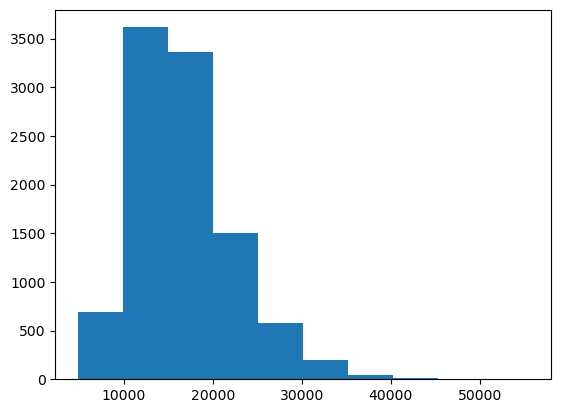

In [10]:
x = np.random.lognormal(1,3,size = (1000, 10000))
_ = plt.hist(np.quantile( x, 0.9, axis = 0)**2)

Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">

Где здесь какая ошибка?

In [2]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

# Как на самом деле сосчитать размер выборки. 

## Допустим, мы считаем наш CTR

In [13]:
q = """
select views, count() as users
from (select  
    exp_group,
    user_id,
    sum(action = 'view') as views
from simulator.feed_actions
where toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (0,1,2,3,4)
group by exp_group, user_id
)
group by views
order by views
"""


# views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [23]:
views_distribution = pd.read_csv('views.csv')

In [24]:
views_distribution

,views,users
0,1,7
1,2,2
2,3,1
3,4,1
4,5,3
...,...,...
315,342,1
316,364,1
317,366,1
318,369,1


In [31]:
# views_distribution

In [5]:
views_distribution.users.sum()

42585

In [6]:
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [7]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
14,15,542,0.012727
15,16,526,0.012352
16,17,525,0.012328
32,33,489,0.011483
13,14,488,0.011459
...,...,...,...
292,294,1,0.000023
293,296,1,0.000023
294,297,1,0.000023
297,300,1,0.000023


## Вот наше настоящее распределение просмотров

In [8]:
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [9]:
views_distr.mean()

73.85382176822824

In [11]:
views_distr.median()

64.0

In [13]:
views_distr.std()

48.81936403773504

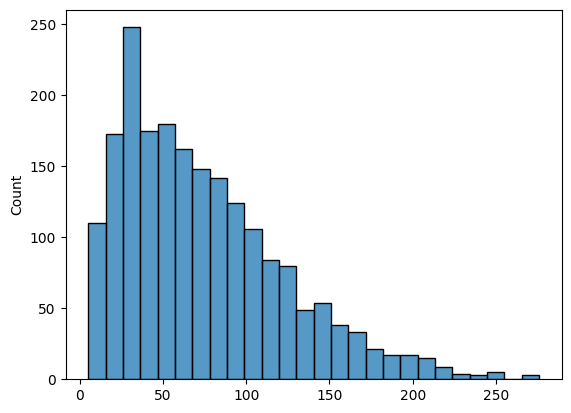

In [10]:
sns.histplot(views_distr.rvs(size=2000))

plt.show()

У $CTR$ разброс где-то от 0.2 до 0.22 по дням. Запомним это)

Достанем распределение CTR'ов за неделю

In [11]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where dt between '2021-11-08' and '2021-11-14'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)
group by ctr
"""


# ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
# ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [12]:
ctr_distribution = pd.read_csv('ctrs.csv')

In [13]:
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,5160,0.060302
32,0.16,4286,0.050088
6,0.18,4266,0.049855
49,0.25,4048,0.047307
27,0.17,4022,0.047003
...,...,...,...
19,0.80,1,0.000012
56,0.76,1,0.000012
64,0.90,1,0.000012
29,0.59,1,0.000012


In [14]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y, distrib, values):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

Так, средний CTR у нас был 0.21. допустим, мы хотим замечать изменение на 0.01 (то есть это на 5%)

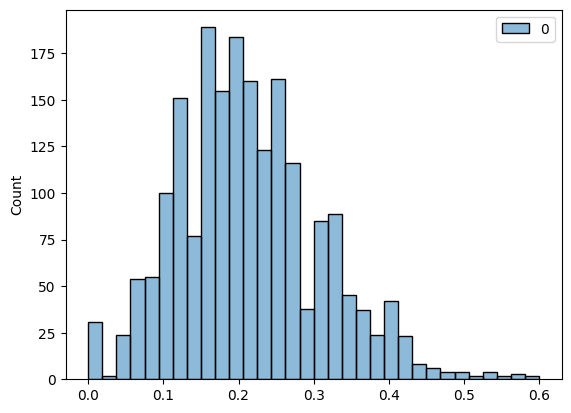

In [15]:
sns.histplot(get_ctrs(2000, 1, distrib, values))
plt.show()

In [26]:
get_ctrs(2000, 1, distrib, values).mean()

0.21102500000000005

# Синтетический А-А тест

In [16]:
q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where dt between '2021-11-08' and '2021-11-14'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)

"""

# std = pandahouse.read_clickhouse(q, connection=connection).values[0][0]
std = 0.0960210145931454
std

0.0960210145931454

In [17]:
compute_sample_size_abs(0.01, std, std)

1448

In [21]:
0.21*1.05

0.2205

In [21]:
group_A_views = views_distr.rvs(size = (1000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (1000, 2000)).astype("int32")
group_A_ctr = get_ctrs(1000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(1000,2000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [19]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(
        x[0], x[1], equal_var=False).pvalue, zip(a, b)))
    return np.array(result)

In [22]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/1000

0.842

In [29]:
# t_test(clicks_A, clicks_B)

In [30]:
def mannwhitney(a, b):
    """
    Считает p-value для теста Манна-Уитни с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value теста Манна-Уитни для всего списка экспериментов
    """
    result = list(map(lambda x: stats.mannwhitneyu(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [31]:
np.sum(mannwhitney(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/1000

0.754

# Бакетное преобразование

In [32]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [33]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

In [37]:
p_values_ab = t_test_buckets(
        clicks_A/group_A_views, group_A_views,
        clicks_B/group_B_views, group_B_views)

In [38]:
np.sum(p_values_ab<= 0.05)/1000

0.714

# Линеаризация

In [39]:
group_A_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_A_ctr = get_ctrs(2000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 2000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [40]:
control_ctr = stats.binom.rvs(group_B_views, group_B_ctr).sum(axis = 1)/group_B_views.sum(axis = 1)

In [41]:
linearized_A = clicks_A - (group_A_views.T*control_ctr).T
linearized_B = clicks_B - (group_B_views.T*control_ctr).T

In [42]:
linearization_p_values = t_test(linearized_A, linearized_B)

In [43]:
sum(linearization_p_values<=0.05)/2000

0.732

# А на самом деле просмотры обычно выглядят не так...

In [25]:
mu = 1
sigma2 = 1.5
N = 1447
experiments = 1000
views_lognormal = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

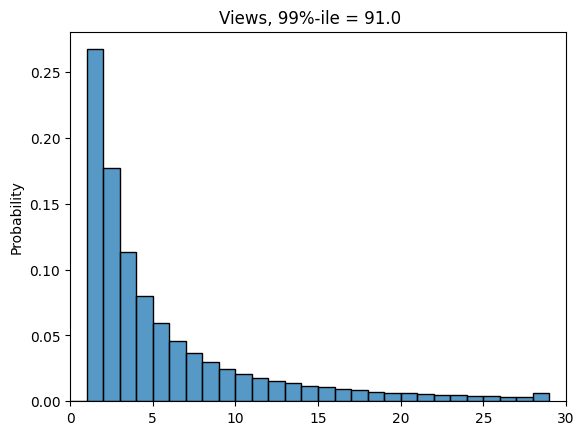

In [26]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_lognormal.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_lognormal.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')
plt.show()

In [32]:
mu_1 = 1
sigma_1 = 1.5
N = 10000
experiments = 1000
views_lognormal1 = np.absolute(np.exp(norm(mu_1, sigma_1).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)


mu_1 = 1
sigma_1 = 1.5
N = 10000
experiments = 1000
views_lognormal2 = np.absolute(np.exp(norm(mu_1, sigma_1).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)*1.01



In [ ]:
exp_mu_1 = np.exp(mu+sigma**2/2)
var_mu_1 = (np.exp(sigma**2)-1)*np.exp(2*mu+sigma**2)

In [33]:
views_lognormal1.std(), views_lognormal2.std()

(24.30377029805199, 24.533407488454912)

In [37]:
views_lognormal1.mean()*0.01

0.088875976

In [38]:
compute_sample_size_abs(0.09, views_lognormal1.std(), views_lognormal2.std())

1155589

In [69]:
signals = 10 

p1 = 0.3
epsilon = 0.01

N = 1000
days = 7


In [70]:
A = stats.binom.rvs(10, p1, size = (1000, N, days)).sum(axis =2)
B = stats.binom.rvs(10, p1+epsilon, size = (1000,N,days)).sum(axis =2)

In [71]:
(t_test(A,B)<=0.05).mean()

0.989

In [51]:
A

array([[5, 2, 2, ..., 3, 2, 2],
       [6, 4, 2, ..., 1, 1, 4],
       [3, 3, 3, ..., 0, 4, 1],
       ...,
       [6, 3, 4, ..., 3, 4, 6],
       [3, 2, 2, ..., 2, 3, 3],
       [2, 2, 3, ..., 4, 1, 3]])

array([1.94813556e-37, 3.02467886e-46, 1.32973291e-41, 3.05877195e-26,
       3.16786289e-35, 1.42555769e-45, 4.26645322e-32, 1.55854539e-34,
       1.32009262e-41, 2.51139912e-38, 1.35967079e-32, 1.21598900e-28,
       6.12353456e-36, 8.80910022e-34, 3.95317618e-27, 2.50716096e-35,
       5.98882371e-33, 6.27194924e-36, 3.94435465e-31, 1.52249139e-42,
       5.65222105e-38, 1.42295346e-30, 1.61238411e-32, 4.68175835e-38,
       9.83443743e-37, 4.32932189e-42, 6.27655035e-33, 4.92643247e-49,
       7.25662309e-36, 2.25491227e-30, 1.25764455e-33, 2.18806567e-31,
       1.32040991e-39, 2.37873303e-33, 3.92681904e-37, 5.35785495e-29,
       5.30773274e-27, 2.99687782e-32, 3.02284840e-39, 1.19161215e-24,
       2.28996082e-35, 1.61944288e-34, 2.67584567e-30, 3.22395253e-31,
       5.04520786e-28, 2.32381600e-31, 2.35013292e-35, 8.90133919e-33,
       7.54850373e-34, 6.92425487e-26, 9.24320990e-37, 2.44601362e-33,
       1.60864319e-42, 3.32064419e-23, 7.24891750e-33, 2.57070062e-28,
      

In [27]:
def get_views(experiments, N, mu = 1, sigma = 1.5):
    views_lognormal = np.absolute(
        np.exp(
            norm(mu, 
                 sigma2).rvs(experiments * N)
        ).astype(np.int64).reshape(experiments, N) + 1)
    return views_lognormal

In [30]:
group_A_views = get_views(2000, 12000).astype("int32")
group_B_views = get_views(2000, 12000).astype("int32")
group_A_ctr = get_ctrs(2000, 12000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000, 12000, distrib, values)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [50]:
(clicks_A[0]/group_A_views[0]).std()

0.2866047930404547

In [29]:
compute_sample_size_abs(0.01, 0.28, 0.28)

12308

In [51]:
(clicks_B/group_B_views).std(axis = 1)[0]

0.2729883733226186

In [31]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.831

In [53]:
np.sum(t_test_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

0.8135

# А если я хочу сдвинуть медиану ...

In [54]:
def bucketization_median(ctrs_0, ctrs_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.median(ctrs_0[:, ind], axis=1)
        values_1[:, b] = np.median(ctrs_1[:, ind], axis=1)

    return values_0, values_1

In [55]:
def mannwhitney_median_buckets(ctrs_0, ctrs_1, n_buckets=100):
    return mannwhitney(*bucketization_median(ctrs_0, ctrs_1, n_buckets))

In [56]:
np.sum(mannwhitney_median_buckets(clicks_A/group_A_views,clicks_B/group_B_views)<= 0.05) /2000

0.6525

# Открытая задача - размен "перекрытия" на длину выборки

In [117]:
df = pd.read_csv('duplicates_matching.csv')

In [156]:
df

,dt,group_id,parent_nm_id,duplicate_nm_id,bucket_id,executor_login,answer,comment
0,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",2e135b08d65255fc4c0386c0c471a0b3,Дубликаты,NaN
1,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",f028c5ec87044b4b7c7670bea1780ae5,Дубликаты,NaN
2,2024-05-03,v1_2024-05-02,d32cb006dc6fe51a8711656978f2fd6d,b54983c6c3c93f0d6e1a1796115c868f,"3,4,5",4242a2448d1e903afaa66da1c8a83390,Дубликаты,NaN
3,2024-05-03,v1_2024-05-02,9177fd909644e4466b81be0544afbe95,2cc66fc06ceddeb5a7355279c420fec7,"1,2",34dceb77fd160d53131640504274a25b,Скип,NaN
4,2024-05-03,v1_2024-05-02,9177fd909644e4466b81be0544afbe95,2cc66fc06ceddeb5a7355279c420fec7,"1,2",34dceb77fd160d53131640504274a25b,Дубликаты,NaN
...,...,...,...,...,...,...,...,...
39075,2024-05-21,v1_2024_05_21,9705aa15732ce72dee21a95d02d884f2,08f3a7176bb8989a5fde0e86a0abbedb,6+,f028c5ec87044b4b7c7670bea1780ae5,Дубликаты,NaN
39076,2024-05-21,v1_2024_05_21,9705aa15732ce72dee21a95d02d884f2,08f3a7176bb8989a5fde0e86a0abbedb,6+,c5ba1d7ad91e7288fb4923a51a7772ba,Дубликаты,NaN
39077,2024-05-21,v1_2024_05_21,cd7d376386733368cbc5850a7af353f4,2a736b62d5eeb87ff24c7cdb40ff8659,6+,7ed92af1c4602e733c9d0540a94e1ce3,Дубликаты,NaN
39078,2024-05-21,v1_2024_05_21,cd7d376386733368cbc5850a7af353f4,2a736b62d5eeb87ff24c7cdb40ff8659,6+,152cab7a30ac4df175370d64bd6cc68c,Дубликаты,NaN


In [119]:
df.answer.unique()

array(['Дубликаты', 'Скип', 'Не дубликаты'], dtype=object)

In [125]:
df[df.answer!= 'Скип'].shape

(31859, 8)

In [128]:
import duckdb

In [160]:
s = "http://basket/images/big/1.jpg"
s2  = "http://basket/images/big/2.jpg"

d = pd.DataFrame()
d['url1'] = [s]
d['url2'] = [s2]

d["image_urls"] = d[["url1", "url2"]].values.tolist()

d[["image_urls"]] = d[[ "image_urls"]].applymap(
            lambda x: str(x).replace("[", "{").replace("]", "}")
        )
d.image_urls[0]

/var/folders/62/5kgnrj396cv9s3jb1nr9_mj40000gn/T/ipykernel_56117/3282578199.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  d[["image_urls"]] = d[[ "image_urls"]].applymap(


"{'http://basket/images/big/1.jpg', 'http://basket/images/big/2.jpg'}"

<Axes: >

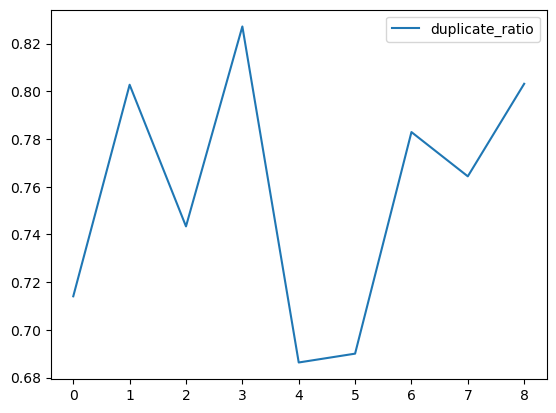

In [137]:
q = '''
SELECT dt, avg(duplicate_flg) as duplicate_ratio
FROM (select dt,
        parent_nm_id, duplicate_nm_id,
        CASE WHEN count_if(answer = 'Дубликаты') >= 2 THEN 1
            ELSE 0 END AS duplicate_flg
    FROM df
    group by dt, parent_nm_id, duplicate_nm_id
    having count(distinct answer) != 3
        and count_if(answer = 'Скип') < 2
    ) as a
GROUP BY dt
ORDER BY dt
'''


duckdb.query(q).to_df().plot()

In [142]:
q = '''
select dt,
    parent_nm_id, duplicate_nm_id,
    CASE WHEN count_if(answer = 'Дубликаты') >= 2 THEN 1
        ELSE 0 END AS duplicate_flg,
    CASE WHEN count(distinct answer) = 3
        or count_if(answer = 'Скип') >= 2 THEN 1
    ELSE 0 END AS problem_flg
FROM df
group by dt, parent_nm_id, duplicate_nm_id
'''

df_for_bootstrap = duckdb.query(q).to_df()

In [143]:
df_for_bootstrap

,dt,parent_nm_id,duplicate_nm_id,duplicate_flg
0,2024-05-03,9177fd909644e4466b81be0544afbe95,2cc66fc06ceddeb5a7355279c420fec7,1
1,2024-05-03,598b615c1a11df61b18d5a37b94a0372,a729d228fa62d93c198e608043568332,1
2,2024-05-03,8026251bd001189713a23dd0dfd3d16a,3520ddf774adaddf000c6f96c804a00c,1
3,2024-05-03,09fcfb238baedefbf7b89eef066d1a09,30e89dcf1b1532700828e7425d5f9d78,1
4,2024-05-03,53a03a3bfdc74345da8d0424d7c26cf7,ba5c5de7f05ea0064f0386dd108740ec,1
...,...,...,...,...
10496,2024-05-21,17971a03d8874d40d73b40d1e82533cf,04cb91368025220f388adaf15382cc3c,1
10497,2024-05-21,6f116e07408a389e87d6cdc77c304e63,8d856073fb24f1d3b9e51353f4e885ad,1
10498,2024-05-21,9cfe969b12f94a5f1e361090daa3c5cd,2473c897c83b9559edaaeac8a7338c78,1
10499,2024-05-21,c31da01f09af811873e50f2ac19f8a44,9b0c302585651b2bd4fe1b8b6c1fde2f,1


In [145]:
with_cross_val = df_for_bootstrap.duplicate_flg.to_numpy()

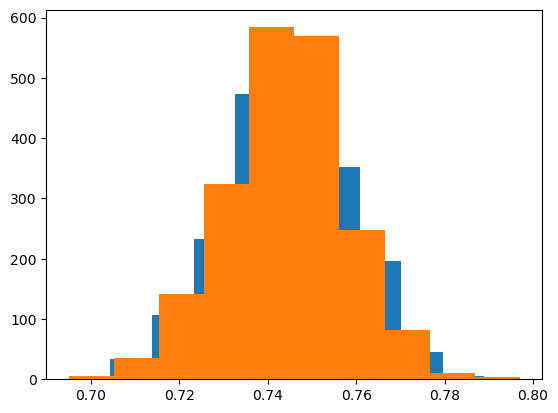

In [155]:
_ = plt.hist(np.random.choice(with_cross_val, size = (2000,1000), replace = True).mean(axis = 1))
_ = plt.hist(np.random.choice(no_cross_val, size = (2000,1000), replace = True).mean(axis = 1))

In [150]:
q = '''
SELECT dt,
        parent_nm_id, duplicate_nm_id, answer
FROM (select dt,
        parent_nm_id, duplicate_nm_id, answer,
        row_number() over (partition by dt, parent_nm_id, duplicate_nm_id
                         order by random()) as rn
        
    FROM df
    ) as a
WHERE rn = 1
    AND answer != 'Скип'
'''

df_for_bootstrap2 = duckdb.query(q).to_df()

In [151]:
no_cross_val = df_for_bootstrap.duplicate_flg.to_numpy()

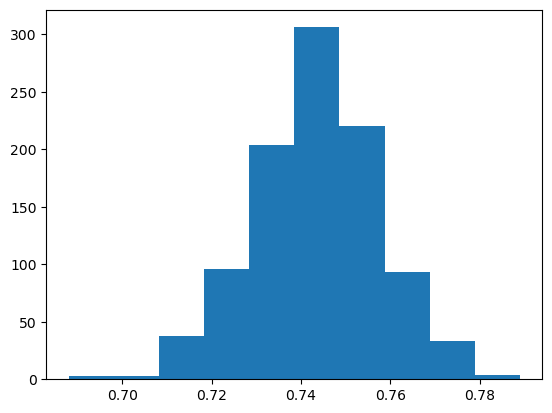